In [172]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_pickle('data/!main_df.pkl')

## Model Selection

This notebook should include preliminary and baseline modeling.
- Try as many different models as possible.
- Don't worry about hyperparameter tuning or cross validation here.
- Ideas include:
    - linear regression
    - support vector machines
    - random forest
    - xgboost

In [173]:
X = df.drop(columns=['sold_price'])
y = df['sold_price']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

# Define numerical and categorical columns
num_cols = ['beds', 'baths', 'busstops', 'sqft']
cat_cols = ['type', 'state']  

# Define preprocessing pipeline
num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols)
    ]
)

# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'Support Vector Machine': SVR(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(eval_metric='rmse')
}

# Prepare a dictionary to store the results
results = {}

# Loop over each model, create a pipeline, and fit
for model_name, model in models.items():
    # Create pipeline with preprocessing and the model
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    # Fit the pipeline
    pipeline.fit(x_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(x_test)
    
    # Calculate the evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    rtwo = r2_score(y_test, y_pred)
    results[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'r2': rtwo
    }

# Display results
print("Baseline Model Performance:")
for model_name, metrics in results.items():
    print(f"{model_name} - MSE: {metrics['MSE']:.2f}, RMSE: {metrics['RMSE']:.2f}, MAE: {metrics['MAE']:.2f}, R2: {metrics['r2']:.2f}")


b:\LHL\python\.conda\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
b:\LHL\python\.conda\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Baseline Model Performance:
Linear Regression - MSE: 42735442470.97, RMSE: 206725.52, MAE: 134057.19, R2: 0.58
Support Vector Machine - MSE: 102463447186.46, RMSE: 320099.12, MAE: 179204.89, R2: -0.00
Random Forest - MSE: 43428464511.84, RMSE: 208394.97, MAE: 111236.94, R2: 0.58
XGBoost - MSE: 46832895111.24, RMSE: 216409.09, MAE: 109920.83, R2: 0.54


b:\LHL\python\.conda\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
b:\LHL\python\.conda\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Consider what metrics you want to use to evaluate success.
- If you think about mean squared error, can we actually relate to the amount of error?
- Try root mean squared error so that error is closer to the original units (dollars)
- What does RMSE do to outliers?
- Is mean absolute error a good metric for this problem?
- What about R^2? Adjusted R^2?
- Briefly describe your reasons for picking the metrics you use

In [174]:
# gather evaluation metrics and compare results

## Feature Selection - STRETCH

> **This step doesn't need to be part of your Minimum Viable Product (MVP), but its recommended you complete it if you have time!**

Even with all the preprocessing we did in Notebook 1, you probably still have a lot of features. Are they all important for prediction?

Investigate some feature selection algorithms (Lasso, RFE, Forward/Backward Selection)
- Perform feature selection to get a reduced subset of your original features
- Refit your models with this reduced dimensionality - how does performance change on your chosen metrics?
- Based on this, should you include feature selection in your final pipeline? Explain

Remember, feature selection often doesn't directly improve performance, but if performance remains the same, a simpler model is often preferrable. 



In [175]:
# perform feature selection 
# refit models
# gather evaluation metrics and compare to the previous step (full feature set)
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE, SelectFromModel


### Lasso

In [176]:
X_train_np = x_train[num_cols].values
X_test_np = x_test[num_cols].values

lasso = Lasso(alpha=0.01).fit(X_train_np, y_train)
model = SelectFromModel(lasso, prefit=True)
x_train_lasso = model.transform(X_train_np)
x_test_lasso = model.transform(X_test_np)
selected_features_mask = model.get_support()
selected_features = np.array(num_cols)[selected_features_mask]

print("Selected features:", selected_features)
print("Original feature count:", x_train.shape[1])

Selected features: ['beds' 'baths' 'busstops' 'sqft']
Original feature count: 169


In [177]:
model = XGBRegressor(eval_metric='rmse')
model.fit(x_train_lasso, y_train)
y_pred = model.predict(x_test_lasso)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Performance on Lasso-selected features:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")

Performance on Lasso-selected features:
Mean Squared Error: 138463002812.44
Root Mean Squared Error: 372106.17
Mean Absolute Error: 196206.09
R2 Score: -0.35


# Bus Stops

## Question: Does the number of bus stops near a property have an impact on house prices?

In [178]:
df = pd.read_pickle('data/!main_df.pkl')

### Creating dataframe with target and parameter

In [179]:
df = df[['sold_price', 'busstops']]

In [180]:
x = df.drop(columns=['sold_price'])
y = df[['sold_price']]

### Removing outliers

In [181]:
Q1 = df['sold_price'].quantile(0.25)
Q3 = df['sold_price'].quantile(0.75)
IQR = Q3 - Q1

low_balls = Q1 - 1.5 * IQR
high_balls = Q3 + 1.5 * IQR

# Filter out the outliers
df = df[(df['sold_price'] >= low_balls) & (df['sold_price'] <= high_balls)]


### Creating bins and then encoding bus stops

In [182]:
bins = [0, 4, 10, 100]
labels = ['<5', '5-10', '11-99']

x['busstops_binned'] = pd.cut(x['busstops'], bins=bins, labels=labels, include_lowest=True)
x = pd.get_dummies(x, columns=['busstops_binned'], drop_first=True)
x = x.drop(columns=['busstops'])

### Splitting the data

In [183]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.3)

### KNN

In [184]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(x_train, y_train)
score = model.score(x_test, y_test)

### Linear Regression

In [185]:
pipeline = Pipeline([("imputer", SimpleImputer()), ("scaler", StandardScaler()), ("model", LinearRegression())])

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
pipeline.score(x_test, y_test)

0.038700607180807034

### Random Forest

In [186]:
y_train = y_train.values.ravel()
pipeline = Pipeline([("imputer", SimpleImputer()), ("scaler", StandardScaler()), ("model", RandomForestRegressor())])

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
pipeline.score(x_test, y_test)

0.039248993646225916

### XGBoost

In [187]:
pipeline = Pipeline([("imputer", SimpleImputer()), ("scaler", StandardScaler()), ("model", XGBRegressor())])

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
pipeline.score(x_test, y_test)

0.03870058059692383

## Results

There is no signifiant coorelation between bus stops and house sale price. Running the data on busstops directly and trying binning had no impact of the model scores. Further analysis is futile. 

# Rooms

## Question: Which rooms impact the value of the house? 

In [188]:
df = pd.read_pickle('data/!main_df.pkl')

### Creating the dataframe

In [189]:
df = df[[ 'sold_price','sqft', 'beds', 'baths', 'den_or_office', 'dining_room', 'family_room', 'game_room', 'laundry_room', 'media_room', 'theater_room']].copy()

In [190]:
Q1 = df['sold_price'].quantile(0.25)
Q3 = df['sold_price'].quantile(0.75)
IQR = Q3 - Q1

low_balls = Q1 - 1.5 * IQR
high_balls = Q3 + 1.5 * IQR

# Filter out the outliers
df = df[(df['sold_price'] >= low_balls) & (df['sold_price'] <= high_balls)]


In [191]:
df.loc[:, 'total_rooms'] = df[['beds', 'baths', 'dining_room', 'den_or_office', 'family_room', 'game_room', 'laundry_room', 'media_room', 'theater_room']].sum(axis=1)

In [192]:
df['extra_rooms'] = df[['den_or_office', 'media_room', 'theater_room', 'game_room', 'laundry_room', 'dining_room', 'family_room']].sum(axis=1)
df.drop(columns=['den_or_office', 'media_room', 'theater_room', 'game_room', 'laundry_room','dining_room', 'family_room'], inplace=True)


### Splitting the data

In [193]:
x = df.drop(columns=['sold_price'])
y = df['sold_price']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3, random_state=42)

In [194]:
with open('data/trained_rooms.pkl', 'wb') as file:
    pickle.dump((x_train, x_test, y_train, y_test), file)

### KNN

In [195]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(x_train, y_train)
model.score(x_test, y_test)

-0.1294348514321444

### Linear Regression

In [196]:
pipeline = Pipeline([("imputer", SimpleImputer()), ("scaler", StandardScaler()), ("model", LinearRegression())])

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
pipeline.score(x_test, y_test)

0.16818937427964686

### Random Forest

In [197]:
pipeline = Pipeline([("imputer", SimpleImputer()), ("scaler", StandardScaler()), ("model", RandomForestRegressor())])

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
pipeline.score(x_test, y_test)

-0.09761690671785384

### XGBooster

In [198]:
pipeline = Pipeline([("imputer", SimpleImputer()), ("scaler", StandardScaler()), ("model", XGBRegressor())])

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
pipeline.score(x_test, y_test)

-0.23384320735931396

## Results

There isn't a strong corelation between rooms and price. I included square footage to give the model a bit of a boost. This question will go into hyperparameter processing because it's the only one that had a positive score.

# tags prices

In [199]:
# Data Setup
df = pd.read_pickle('data/!main_df.pkl')
tags_df = df.drop(['sold_price','address','city','coords_lat','coords_lon','state','type','beds','garage','baths','sqft','baths_half','baths_full','permalink'],axis=1)
property_tag_count = tags_df.sum(1)
property_price_df = df[['sold_price']]
property_price_df['tags_count'] = property_tag_count
df = property_price_df

x= df.drop(columns=['sold_price'])
y=df[['sold_price']]

# Find Outliers
Q1 = df['sold_price'].quantile(0.25)
Q3 = df['sold_price'].quantile(0.75)
IQR = Q3 - Q1

low_balls = Q1 - 1.5 * IQR
high_balls = Q3 + 1.5 * IQR

# Filter out the outliers
df = df[(df['sold_price'] >= low_balls) & (df['sold_price'] <= high_balls)]

bins = [0, 4, 10, 100]
labels = ['<5', '5-10', '11-99']

x['tags_binned'] = pd.cut(x['tags_count'], bins=bins, labels=labels, include_lowest=True)
x = pd.get_dummies(x, columns=['tags_binned'], drop_first=True)
x = x.drop(columns=['tags_count'])

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.3)



C:\Users\ElenaFall\AppData\Local\Temp\ipykernel_18992\498720605.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  property_price_df['tags_count'] = property_tag_count


In [200]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(x_train, y_train)
score = model.score(x_test, y_test)
score

0.05384566951565939

In [201]:
pipeline = Pipeline([("imputer", SimpleImputer()), ("scaler", StandardScaler()), ("model", LinearRegression())])

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
pipeline.score(x_test, y_test)

0.06251796931321651

In [202]:
y_train = y_train.values.ravel()
pipeline = Pipeline([("imputer", SimpleImputer()), ("scaler", StandardScaler()), ("model", RandomForestRegressor())])

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
pipeline.score(x_test, y_test)

0.062269294952673526

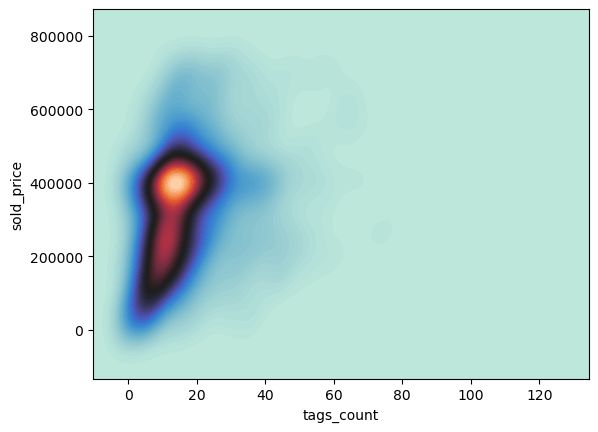

In [203]:
sns.kdeplot(data=df, x='tags_count', y='sold_price', fill=True, thresh=0, levels=100, cmap='icefire')
plt.savefig('images/tags_prices')